In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F


import torchvision
from torchvision import models
from torchvision.transforms import Compose, transforms
from torchvision import datasets, transforms


In [38]:
# Constants  
DATA_PATH = "/raid/cs152/kjaa2018/seatbelt-images/"
CLASSES = ["belt_on", "no_belt"]

# Hyperparameters
batch_size = 64
num_epochs = 10
dropout_rate = 0.15
img_size = 128
resnet_size = (224, 224)

In [22]:
# TODO: Add transform to normalize data 
# QUESTION: How do we compute mean(s) and SD(s) to perform norm

# Create standard transforms 
standard_transforms = transforms.Compose([
    transforms.Resize((img_size, 170)),
    transforms.ToTensor()])

# Create augmented transforms
augmented_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Resize(img_size),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((128, 170), (0.75, 1.0)),
    transforms.ToTensor()])

# Create labeled dataset
data = datasets.ImageFolder(DATA_PATH, transform = standard_transforms)

#another data loader
# loader = DataLoader(data, batch_size=batch_size)

# Grab all images and targets from the loader
# images, labels = next(iter(loader))

# Create augmented labeled dataset (currently not in use)
augmented_data = datasets.ImageFolder(DATA_PATH, transform = augmented_transforms)

In [25]:
# Split dataset into training and validation sets

# TODO: Double check with Prof. Clark that this code does what you think! 

# Compute splitting point for 80% training and 20% validation distribution
num_train = len(data)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))

# Randomly shuffle indices
np.random.seed(4747) # fix seed for reproducibility 
np.random.shuffle(indices)

# Split indices into two groups and create a random sampler for each
train_idx, valid_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Save datatset sizes
dataset_sizes = {'train':split, 'val':num_train-split}

# Create loader for training dataset
train_loader = torch.utils.data.DataLoader(
        data, batch_size=batch_size, sampler=train_sampler
    )

# Create loader for validation dataset
valid_loader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, sampler=valid_sampler
)

dataloaders = {'train':train_loader, 'val':valid_loader}
print(dataset_sizes)

{'train': 108, 'val': 28}


In [28]:
# Try to use gpu if available 
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

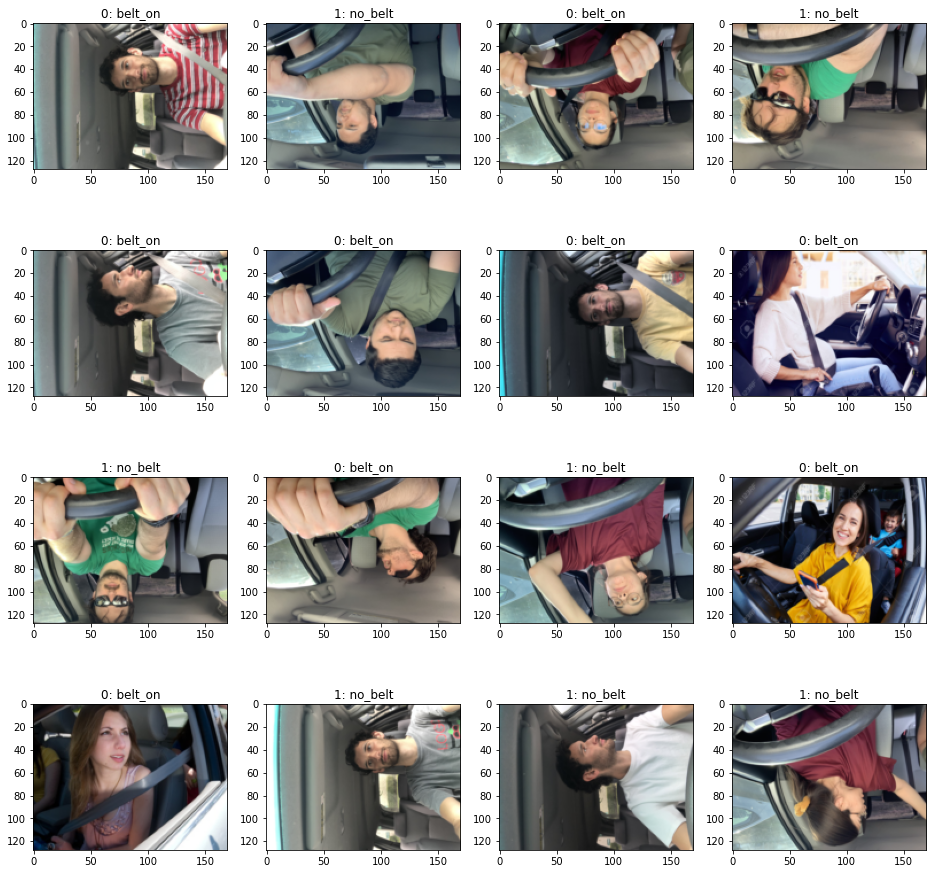

In [30]:
# Get first batch of imgages and labels
images, labels = next(iter(train_loader))

# Plot images and labels in grid 
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(str(labels[i].item()) + ": " + CLASSES[labels[i].item()])
plt.show()

In [31]:
images.shape, labels.shape

(torch.Size([64, 3, 128, 170]), torch.Size([64]))

In [32]:
# FUNCTIONS FOR MODEL TRAINING, EVAL, and VISUALIZATION

# Function to train given model with specified criterion, optimizer, and parameters
def train_model(model, criterion, optimizer, num_pochs):
    
    model.train()
    model.to(device)

    for epoch in range(num_epochs):

        train_loss_total = 0.0

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            optimizer.zero_grad()

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            train_loss_total += loss.item()

        print(f"Training loss at epoch {epoch}/{num_epochs}:", train_loss_total)

    print("Finished Training")
    return model

    
# Test model performance
def eval_model(model):
    
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0

    class_correct = [0 for _ in CLASSES]
    class_total = [0 for _ in CLASSES]

    with torch.no_grad():

        for images, labels in valid_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = outputs.argmax(dim=1, keepdim=True)

            comparisons = predictions.eq(labels.view_as(predictions))
            for comp, label in zip(comparisons, labels):
                class_correct[label] += comp.item()
                class_total[label] += 1

            total += labels.shape[0]
            correct += int(comparisons.double().sum().item())

    accuracy = correct / total
    print(f"Accuracy on validation set: {correct}/{total} = {accuracy*100:.2f}%")

    for i, cls in enumerate(CLASSES):
        ccorrect = class_correct[i]
        ctotal = class_total[i]
        caccuracy = ccorrect / ctotal
        print(f"  Accuracy on {cls:>5} class: {ccorrect}/{ctotal} = {caccuracy*100:.2f}%")

        
# Show some images and prediction from validation set
def visualize_model(model):

    model.eval()
    model.to(device)
    
    images, labels = next(iter(valid_loader))

    with torch.no_grad(): 
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions = outputs.argmax(dim=1, keepdim=True)

    # Plot images and labels in grid 
    w = 10
    h = 10
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.detach().cpu().clone().permute(1,2,0))
        plt.title(str(predictions[i].item()) + ": " + CLASSES[predictions[i].item()])
    plt.show()

In [46]:
# Build simple linear model from scratch

# model = nn.Sequential(
#     nn.Conv2d(3, 6, 5), #try batch norm here
#     nn.ReLU(),
#     # nn.MaxPool2d(2, 2),
#     nn.Conv2d(6, 16, 5),
#     nn.ReLU(),
#     # nn.MaxPool2d(2, 2),
#     nn.Flatten(),
#     nn.Linear(16 * 120 * 162, 120), #find correct values here
#     nn.ReLU(),
#     nn.Linear(120, 84),
#     nn.ReLU(),
#     nn.Linear(84, 2),
# )

# nn.Linear(16 * 5 * 5, 120),
# model = models.resnet18(pretrained=True)


model = model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 128 * 170, 100),
    nn.ReLU(),
    nn.Linear(100, len(CLASSES)),
    nn.Dropout(dropout_rate)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train this model
model = train_model(model, criterion, optimizer, num_epochs)


Training loss at epoch 0/10: 11.924218118190765
Training loss at epoch 1/10: 11.404124736785889
Training loss at epoch 2/10: 10.73734188079834
Training loss at epoch 3/10: 7.186119079589844
Training loss at epoch 4/10: 4.346431136131287
Training loss at epoch 5/10: 3.87063205242157
Training loss at epoch 6/10: 2.2134093046188354
Training loss at epoch 7/10: 1.290198564529419
Training loss at epoch 8/10: 1.305301308631897
Training loss at epoch 9/10: 0.9176080971956253
Finished Training


In [47]:
# Evaluate this model 
eval_model(model)

Accuracy on validation set: 22/28 = 78.57%
  Accuracy on belt_on class: 7/13 = 53.85%
  Accuracy on no_belt class: 15/15 = 100.00%


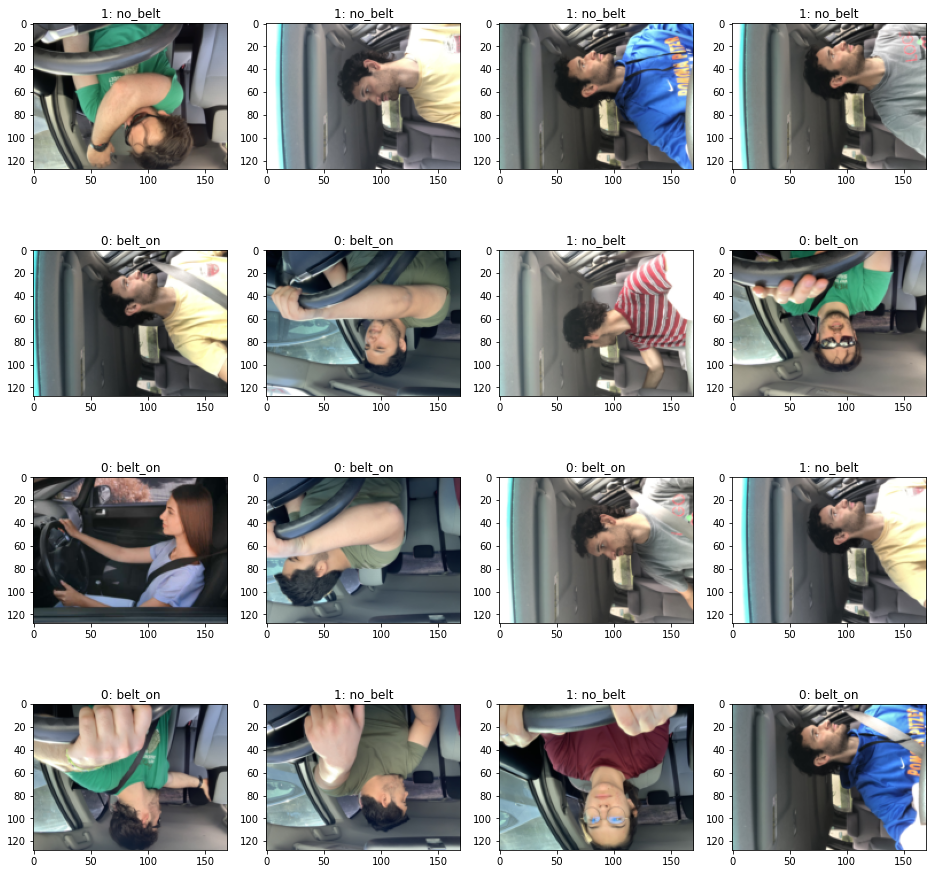

In [45]:
# Visualize the results of training for this model
visualize_model(model)